<a href="https://colab.research.google.com/github/kirill-kozlitin/VTB/blob/main/check_autologreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

Провести тестирование выборки на предмет применимости в тестах
1. Построить автологрег
2. Оценить фичи, которые входят

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install xlsxwriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 2.9 MB/s eta 0:00:00


In [ ]:
!pip install optbinning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 kB 23.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3


In [ ]:
import pandas as pd
import sys

path = 'drive/MyDrive/VTB/'
sys.path.append(path)

import vtb_mlkit
from vtb_mlkit.scorekit.model import LogisticRegressionModel
from vtb_mlkit.scorekit.data import DataSamples


(CVXPY) Jul 21 11:30:51 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jul 21 11:30:51 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


In [ ]:
data = pd.read_csv(path + 'accepted_2007_to_2018Q4.csv.gz', compression='gzip', nrows=1*10**5)

In [ ]:
month_dct = {
    'Jan':'01',
    'Feb':'02',
    'Mar':'03',
    'Apr':'04',
    'May':'05',
    'Jun':'06',
    'Jul':'07',
    'Aug':'08',
    'Sep':'09',
    'Oct':'10',
    'Nov':'11',
    'Dec':'12'
}

data['date'] = data['issue_d'].apply(lambda x: f'01.{month_dct[x[:3]]}.{x[-4:]}')

In [ ]:
data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')

In [ ]:
# data[['term', 'pymnt_plan', 'initial_list_status', 'application_type', 'hardship_flag', 'debt_settlement_flag']]
data['loan_status'].value_counts(dropna=False)

Fully Paid            70288
Charged Off           17603
Current               11402
Late (31-120 days)      441
In Grace Period         199
Late (16-30 days)        66
Default                   1
Name: loan_status, dtype: int64

In [ ]:
data['target'] = data['loan_status'].apply(lambda x: 0 if x == 'Fully Paid' else 1)

In [ ]:
bad_features = ['id', # понятно
                'member_id', # понятно
                'desc', # описание кредита
                'title', # описание кредита
                'last_pymnt_amnt', # сумма посл. платежа. (лик)
                'acc_now_delinq', # кол. просрочек сейчас (лик)
                'total_pymnt', # уплач. сумма (лик)
                'total_pymnt_inv', # уплач. проц (лик)
                'total_rec_prncp', # уплач. сумма (лик)
                'total_rec_int', # уплач. проц (лик)
                'total_rec_late_fee', # уплач. проц (лик)
                'next_pymnt_d', # дата след. платежа (лик)
                'last_pymnt_amnt', # сумма послед. платежа (лик)
                'last_fico_range_low', # рейтинг текущ. (лик)
                'last_fico_range_high', # рейтинг текущ. (лик)
                'loan_status', # текущ. статус (лик)
                ]

In [ ]:
data.drop(bad_features, axis='columns', inplace=True)

In [ ]:
ds = DataSamples(samples={'train': data.copy()}, target='target', time_column='date', result_folder='titanic_output', samples_split={}, bootstrap_split={}, ci_analytic=False)

logreg = LogisticRegressionModel(clf=None,            # классификатор модели (должен иметь метод fit() и атрибуты coef_, intercept_). При None выбирается SGDClassifier(alpha=0.001, loss='log', max_iter=100)
                                 ds=ds,               # Привязанный к модели ДатаСэмпл. Если задан, то он по умолчанию будет использоваться во всех методах
                                 transformer=None,    # объект класса WOE для предварительной трансформации факторов
                                 round_digits=3,      # округление коэффициентов до этого кол-ва знаков после запятой
                                 name='loan',      # название модели
                                )


[INFO] [2023-07-21 12:16:07] ---------------------------------------------------------------- Creating DataSamples ----------------------------------------------------------------
[INFO] [2023-07-21 12:16:08] Selected 123 features: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'pymnt_plan', 'purpose', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il'

[INFO] [2023-07-21 12:31:51] ------------------------------------------------------------------------ SFA -------------------------------------------------------------------------
[INFO] [2023-07-21 12:31:51] Performing autobinning with parameters space of size 1...
[INFO] [2023-07-21 12:31:51] Using parameters set 1/1: {'method': 'opt', 'max_n_bins': 10, 'min_bin_size': 0.05, 'criterion': 'entropy', 'scoring': 'neg_log_loss', 'max_depth': 5, 'solver': 'cp', 'divergence': 'iv', 'WOEM_on': True, 'WOEM_woe_threshold': 0.05, 'WOEM_with_missing': False, 'SM_on': False, 'SM_target_threshold': 5, 'SM_size_threshold': 100, 'G_on': False, 'G_gini_threshold': 5, 'G_gini_decrease_threshold': 0.25, 'G_gini_increase_restrict': False, 'G_with_test': False, 'BL_on': True, 'BL_allow_Vlogic_to_increase_gini': 10, 'WOEO_on': True, 'WOEO_all_samples': False, 'verbose': False}
[INFO] [2023-07-21 12:31:51] Processing 123 features on 1 CPU...


100%|██████████| 123/123 [06:54<00:00,  3.37s/it]


[INFO] [2023-07-21 12:38:47] Excluded 34 features ['pymnt_plan', 'pub_rec', 'out_prncp', 'out_prncp_inv', 'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'dti_joint', 'chargeoff_within_12_mths', 'delinq_amnt', 'mths_since_recent_bc_dlq', 'num_accts_ever_120_pd', 'num_bc_tl', 'num_tl_30dpd', 'pub_rec_bankruptcies', 'tax_liens', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag'] because no suitable binning was found for them
[INFO] [2023-07-21 12:38:47] Scorecard saved to the file titanic_output/auto_fit_scorecard.xlsx
[INFO] [2023-07-21 12:38:47] All done! 89/123 features su

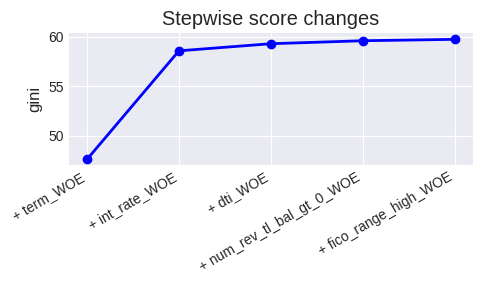

[INFO] [2023-07-21 12:42:57] ---------------------------------------------- Step 4 ----------------------------------------------
[INFO] [2023-07-21 12:42:58] Dropping features with positive coefs and high p-values...
[INFO] [2023-07-21 12:42:58] Nothing to drop
[INFO] [2023-07-21 12:42:58] ------------------------------------------- Final model --------------------------------------------
[INFO] [2023-07-21 12:42:58] intercept = -0.865
[INFO] [2023-07-21 12:42:58] coefs = {'term_WOE': -0.841, 'num_rev_tl_bal_gt_0_WOE': -0.427, 'int_rate_WOE': -0.485, 'fico_range_high_WOE': -0.359, 'dti_WOE': -0.428}
[INFO] [2023-07-21 12:43:00] Generating report...


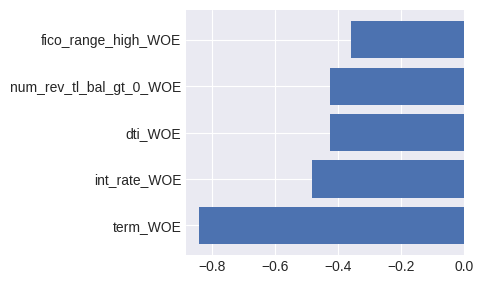

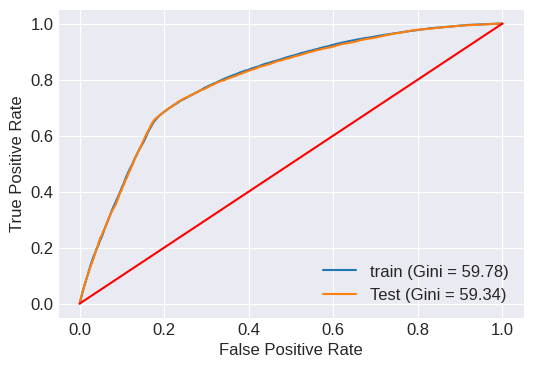

[INFO] [2023-07-21 12:43:46] 
      train   Test  CI_lower  CI_upper
Gini  59.78  59.34     58.94     60.33


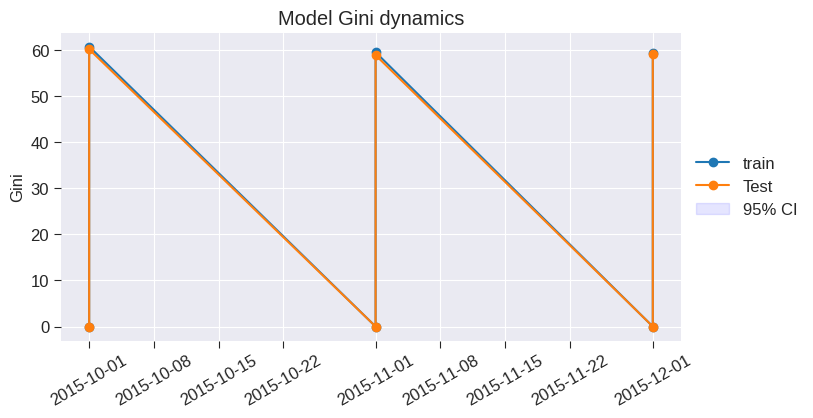

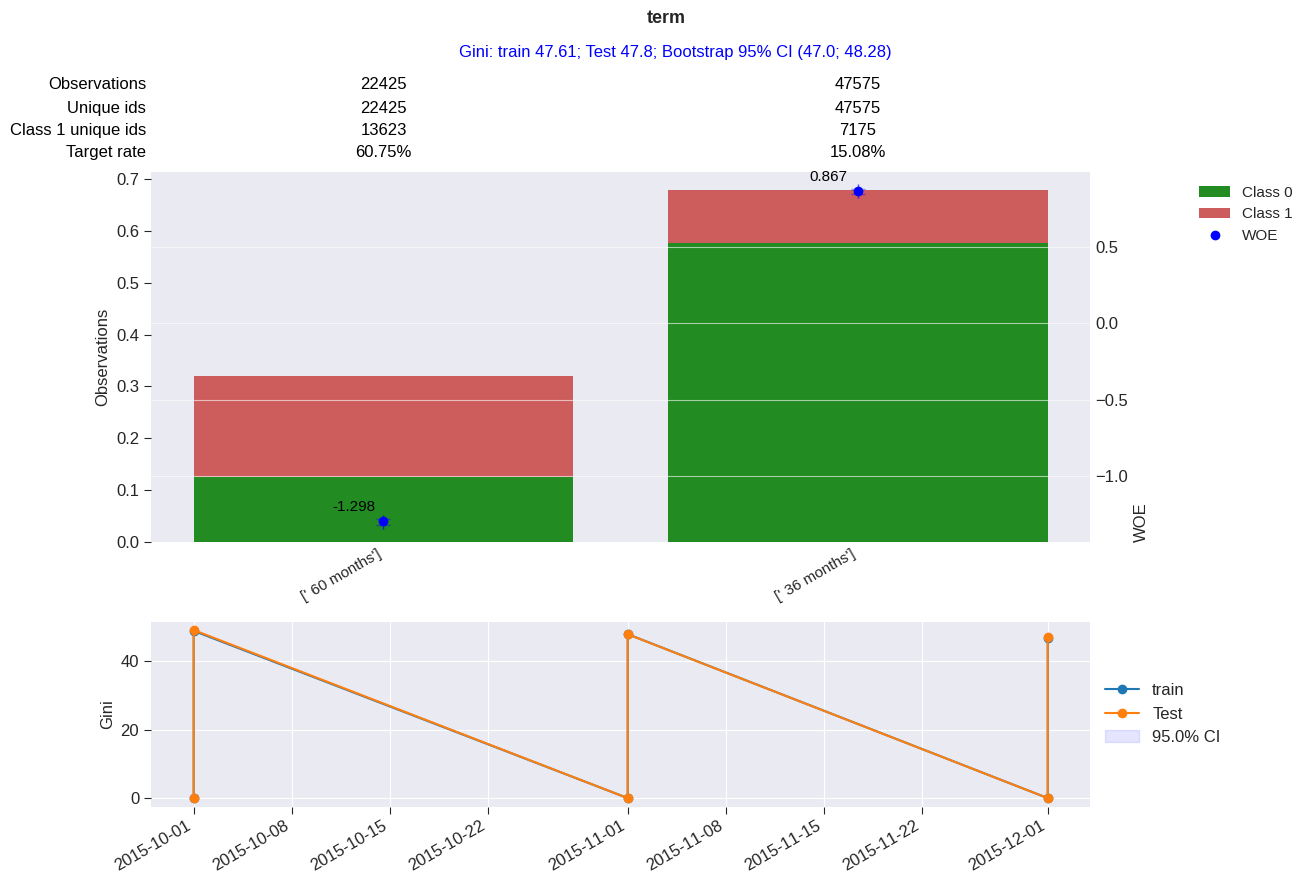

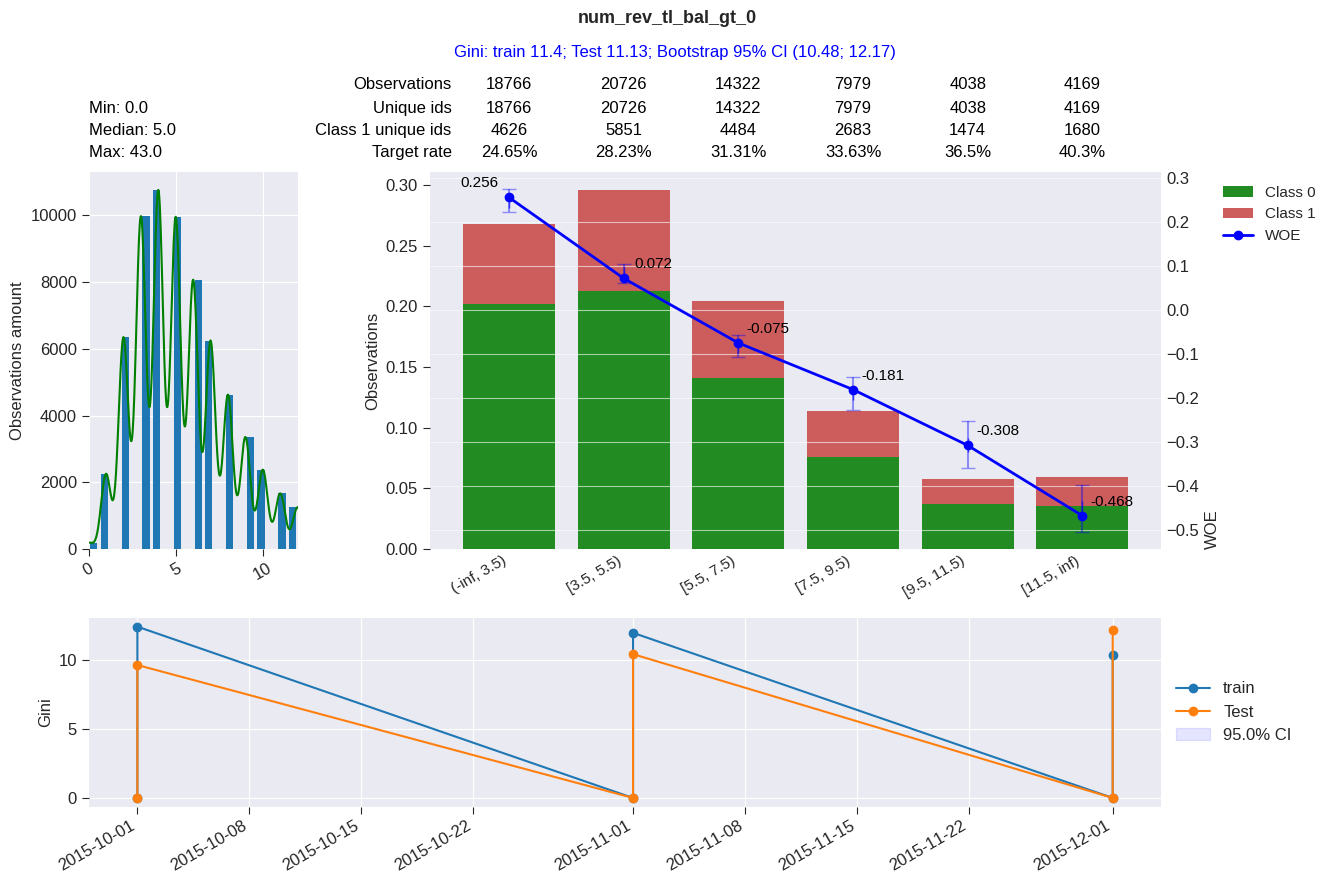

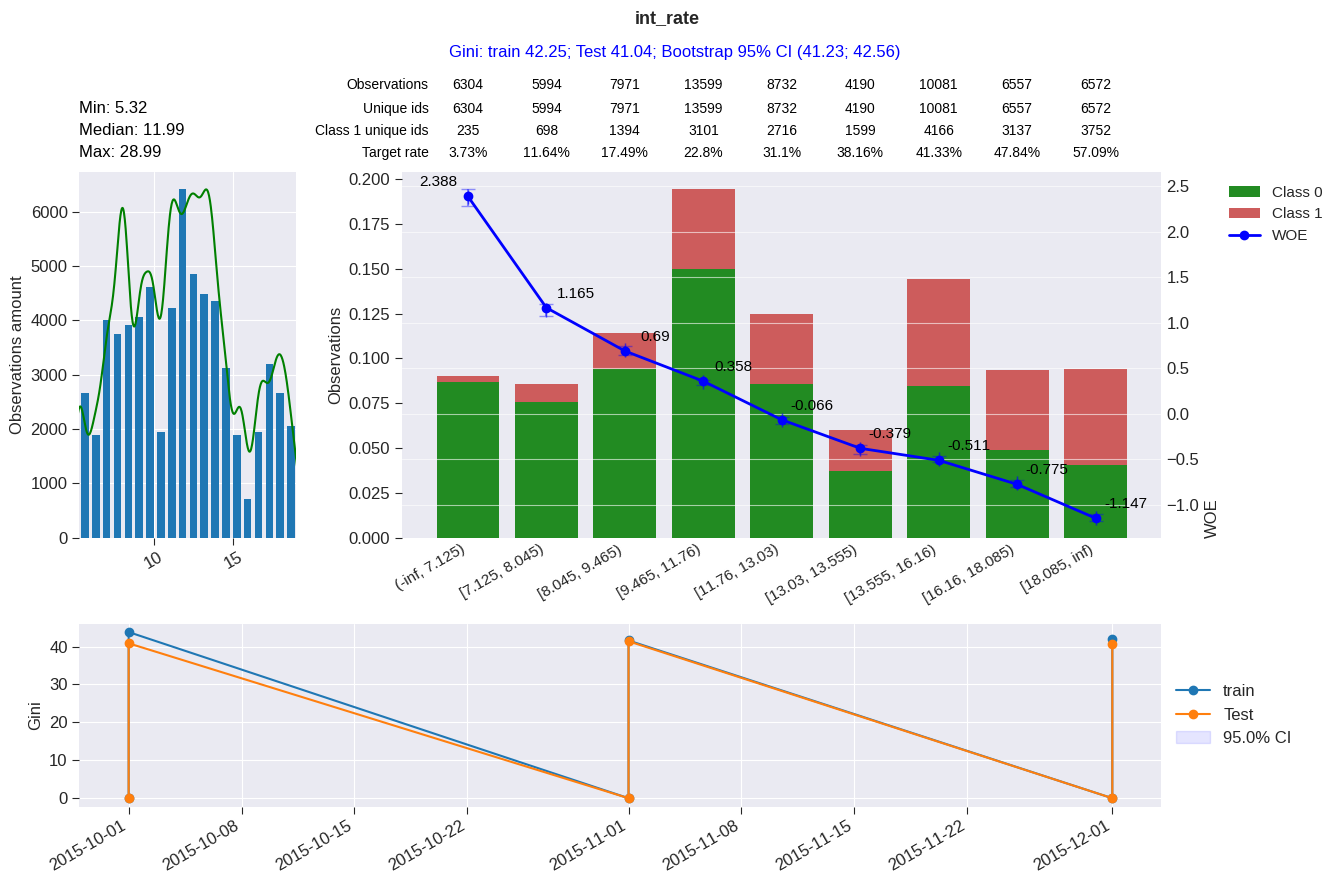

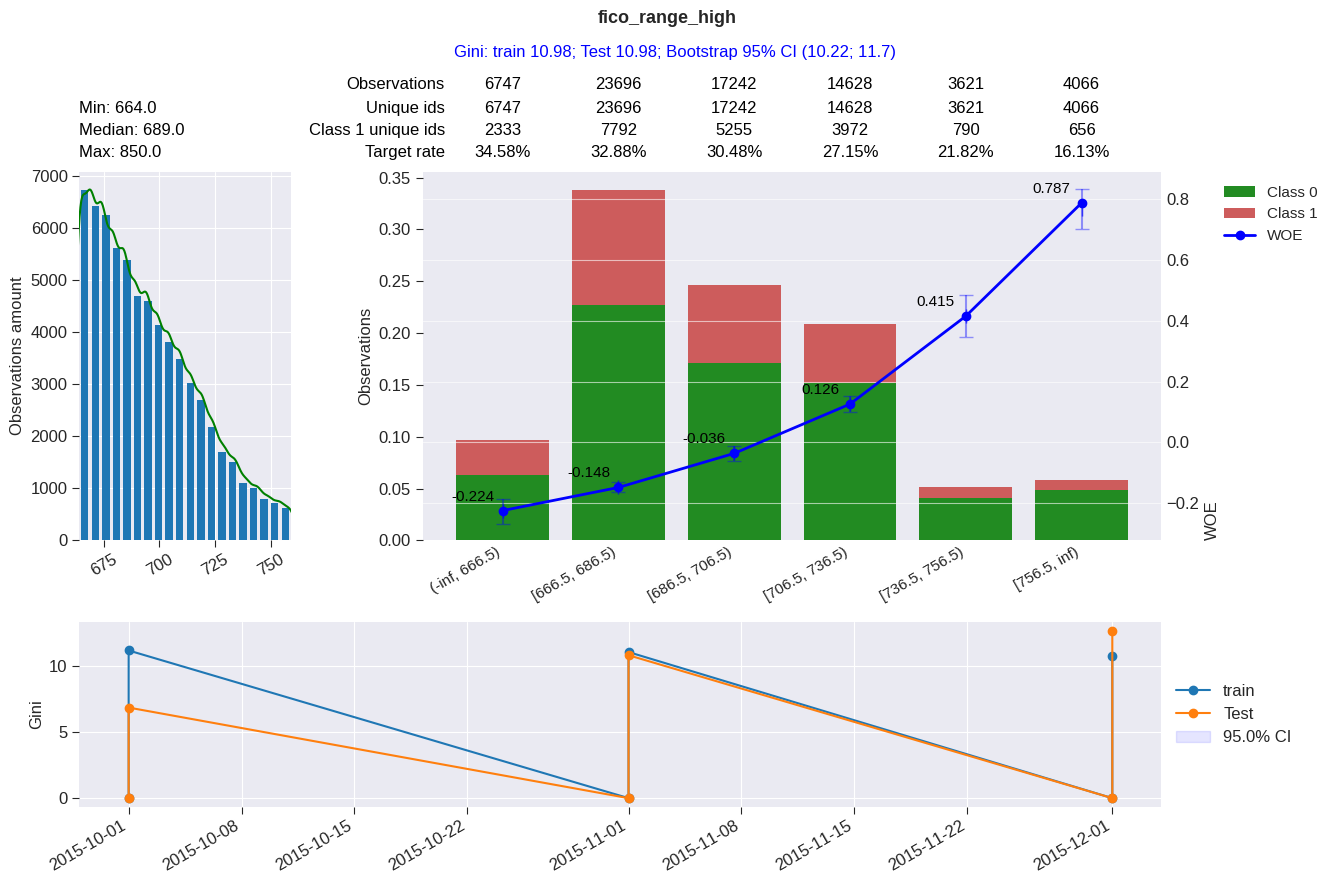

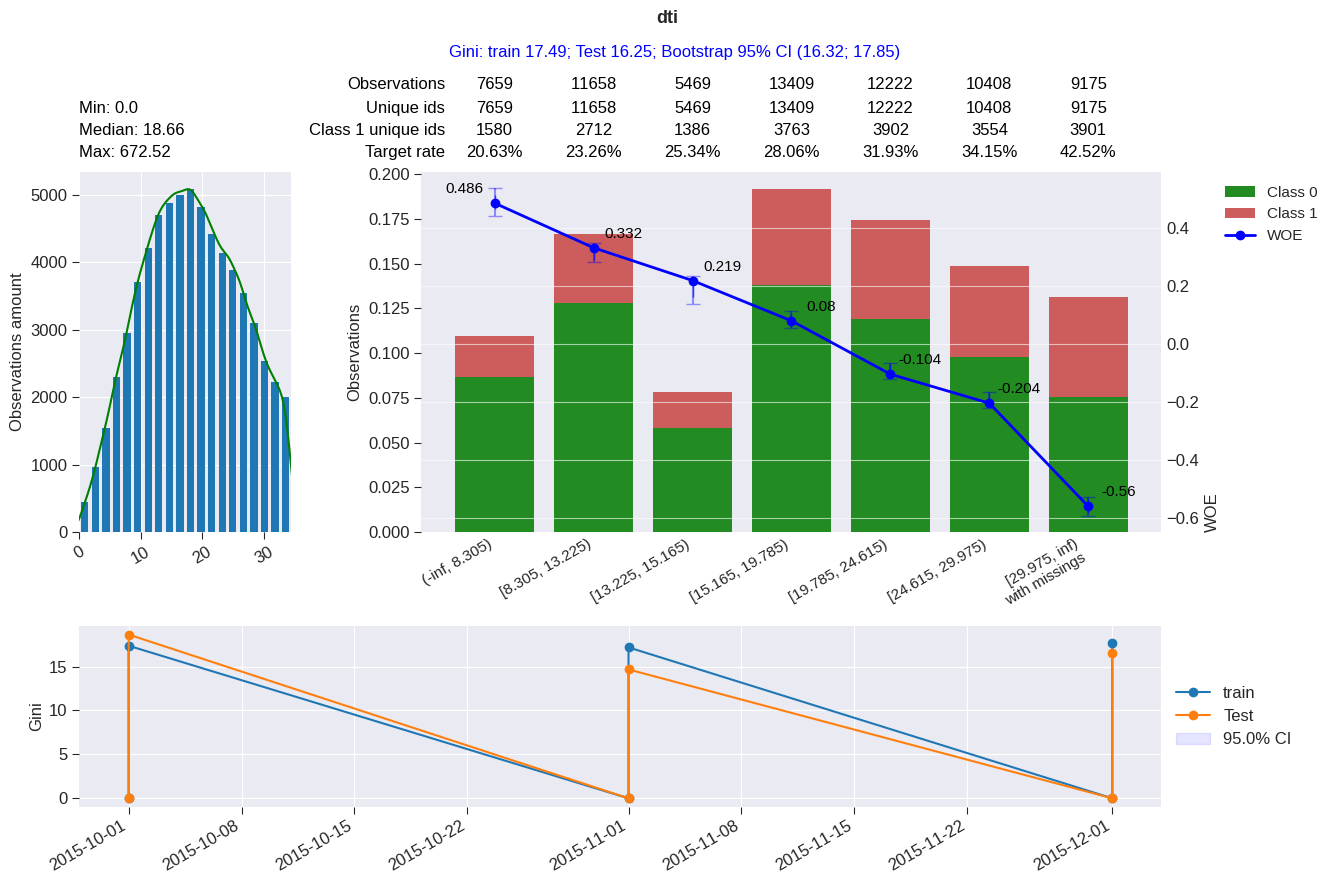

[INFO] [2023-07-21 12:45:44] The model report is saved to file auto_model.xlsx
[INFO] [2023-07-21 12:45:44] The model was successfully saved to file titanic_output/auto_model.json


In [ ]:
logreg.auto_logreg(data=None, target=None, time_column=None, id_column=None, feature_descriptions=None, n_jobs=None,
                   result_folder='', method='opt', validate=False, out='auto_model.xlsx', save_model='auto_model.json')

In [ ]:
# logreg.features

In [ ]:
!pip install tsfresh

In [ ]:
ds = DataSamples(samples={'train': data.copy()}, target='target', result_folder='titanic_output')

[INFO] [2023-07-21 12:45:49] ---------------------------------------------------------------- Creating DataSamples ----------------------------------------------------------------
[INFO] [2023-07-21 12:45:49] Selected 124 features: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'pymnt_plan', 'purpose', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il'

In [ ]:
ds.features

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'pymnt_plan',
 'purpose',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'recoveries',
 'collection_recovery_fee',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_op

In [ ]:
ds.feature_generator(features=None, prebinning=True, chunk_size=10000, gini_threshold=10, operands=True,
                     lags=True, aggs=None, corr_method='spearman', corr_thres=0.80)

[INFO] [2023-07-21 12:45:59] Creating combinations...


100%|██████████| 234/234 [01:16<00:00,  3.05it/s]

[INFO] [2023-07-21 12:47:15] 234 features were generated, 43 of them passed the tests and were added to sample train


In [ ]:
ds.features

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'pymnt_plan',
 'purpose',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'recoveries',
 'collection_recovery_fee',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_op

In [ ]:
ds.samples_split(df=None, test_size=.3, validate_size=0, split_type='oos', stratify=True, id_column=None)

[INFO] [2023-07-21 12:47:16] Actual parts of samples after samples split:
      train  Test
part    0.7   0.3


In [ ]:
logreg = LogisticRegressionModel(clf=None,            # классификатор модели (должен иметь метод fit() и атрибуты coef_, intercept_). При None выбирается SGDClassifier(alpha=0.001, loss='log', max_iter=100)
                                 ds=ds,               # Привязанный к модели ДатаСэмпл. Если задан, то он по умолчанию будет использоваться во всех методах
                                 transformer=None,    # объект класса WOE для предварительной трансформации факторов
                                 round_digits=3,      # округление коэффициентов до этого кол-ва знаков после запятой
                                 name='loan',      # название модели
                                )


[INFO] [2023-07-21 12:47:16] Chosen model classifier is SGDClassifier(alpha=0.001, loss='log', random_state=0)


[INFO] [2023-07-21 14:00:44] ------------------------------------------------------------------------ SFA -------------------------------------------------------------------------
[INFO] [2023-07-21 14:00:44] Performing autobinning with parameters space of size 1...
[INFO] [2023-07-21 14:00:44] Using parameters set 1/1: {'method': 'opt', 'max_n_bins': 10, 'min_bin_size': 0.05, 'criterion': 'entropy', 'scoring': 'neg_log_loss', 'max_depth': 5, 'solver': 'cp', 'divergence': 'iv', 'WOEM_on': True, 'WOEM_woe_threshold': 0.05, 'WOEM_with_missing': False, 'SM_on': False, 'SM_target_threshold': 5, 'SM_size_threshold': 100, 'G_on': False, 'G_gini_threshold': 5, 'G_gini_decrease_threshold': 0.25, 'G_gini_increase_restrict': False, 'G_with_test': False, 'BL_on': True, 'BL_allow_Vlogic_to_increase_gini': 10, 'WOEO_on': True, 'WOEO_all_samples': False, 'verbose': False}
[INFO] [2023-07-21 14:00:44] Processing 167 features on 1 CPU...


100%|██████████| 167/167 [04:07<00:00,  1.48s/it]


[INFO] [2023-07-21 14:04:55] Excluded 39 features ['pymnt_plan', 'mths_since_last_delinq', 'pub_rec', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'max_bal_bc', 'chargeoff_within_12_mths', 'delinq_amnt', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_bc_tl', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'pub_rec_bankruptcies', 'tax_liens', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag'] because no suitable binning was found for them
[INFO] [2023-07-

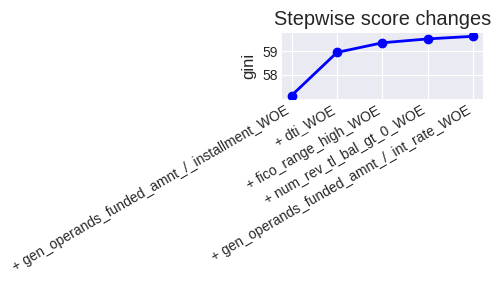

[INFO] [2023-07-21 14:06:19] ---------------------------------------------- Step 4 ----------------------------------------------
[INFO] [2023-07-21 14:06:20] Dropping features with positive coefs and high p-values...
[INFO] [2023-07-21 14:06:20] Nothing to drop
[INFO] [2023-07-21 14:06:20] ------------------------------------------- Final model --------------------------------------------
[INFO] [2023-07-21 14:06:20] intercept = -0.878
[INFO] [2023-07-21 14:06:20] coefs = {'num_rev_tl_bal_gt_0_WOE': -0.423, 'gen_operands_funded_amnt_/_int_rate_WOE': -0.223, 'gen_operands_funded_amnt_/_installment_WOE': -0.967, 'fico_range_high_WOE': -0.467, 'dti_WOE': -0.449}
[INFO] [2023-07-21 14:06:23] Generating report...


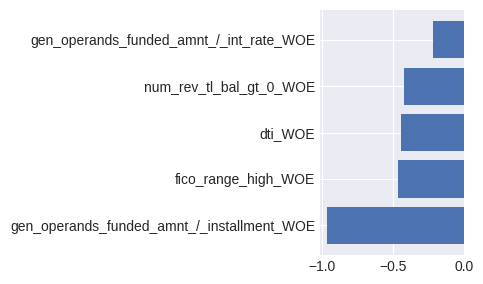

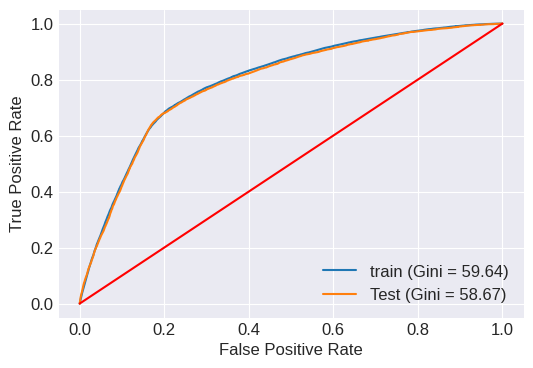

[INFO] [2023-07-21 14:06:27] 
      train   Test  CI_lower  CI_upper
Gini  59.64  58.67     58.85     60.42


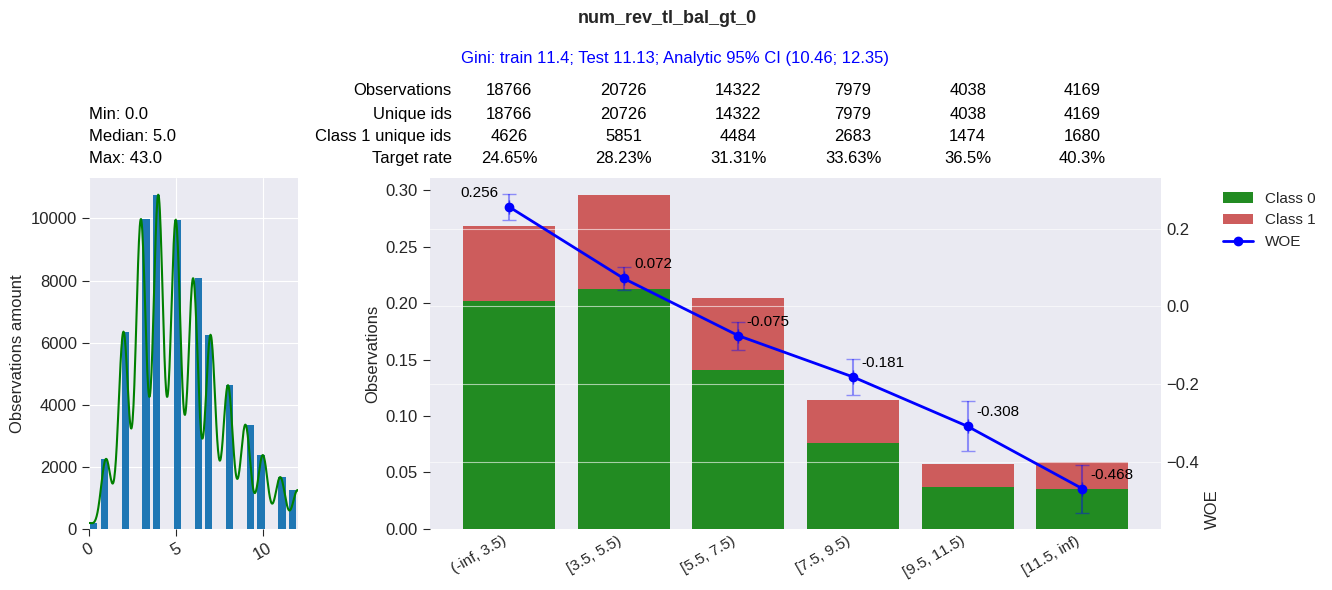

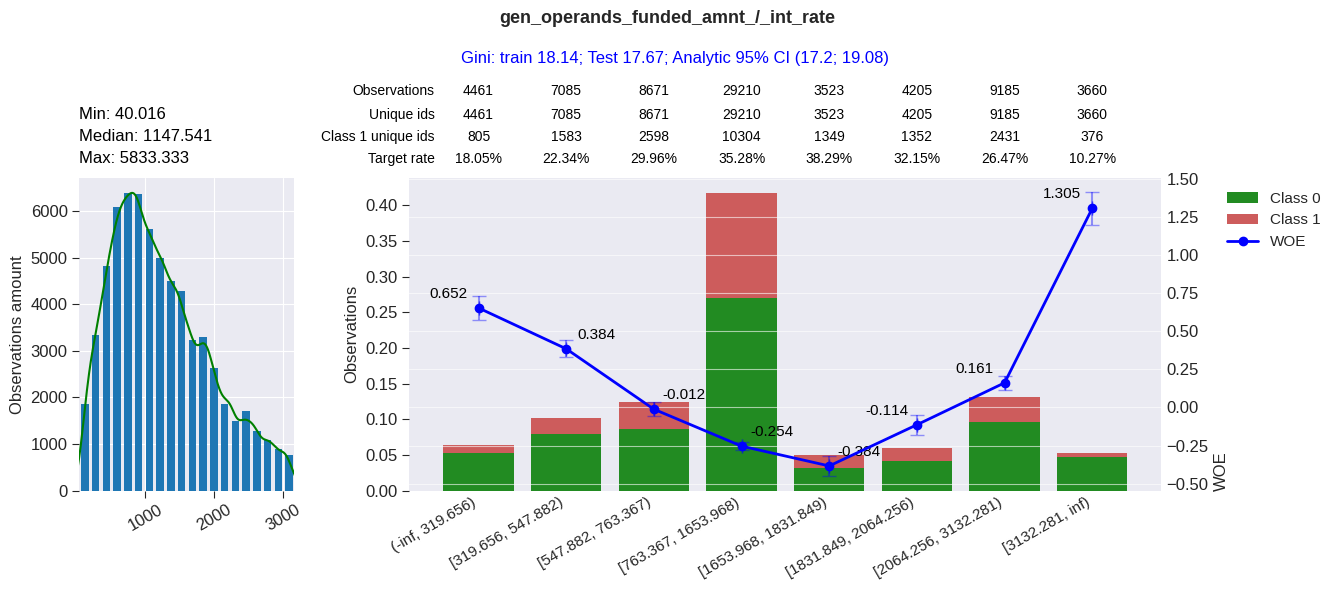

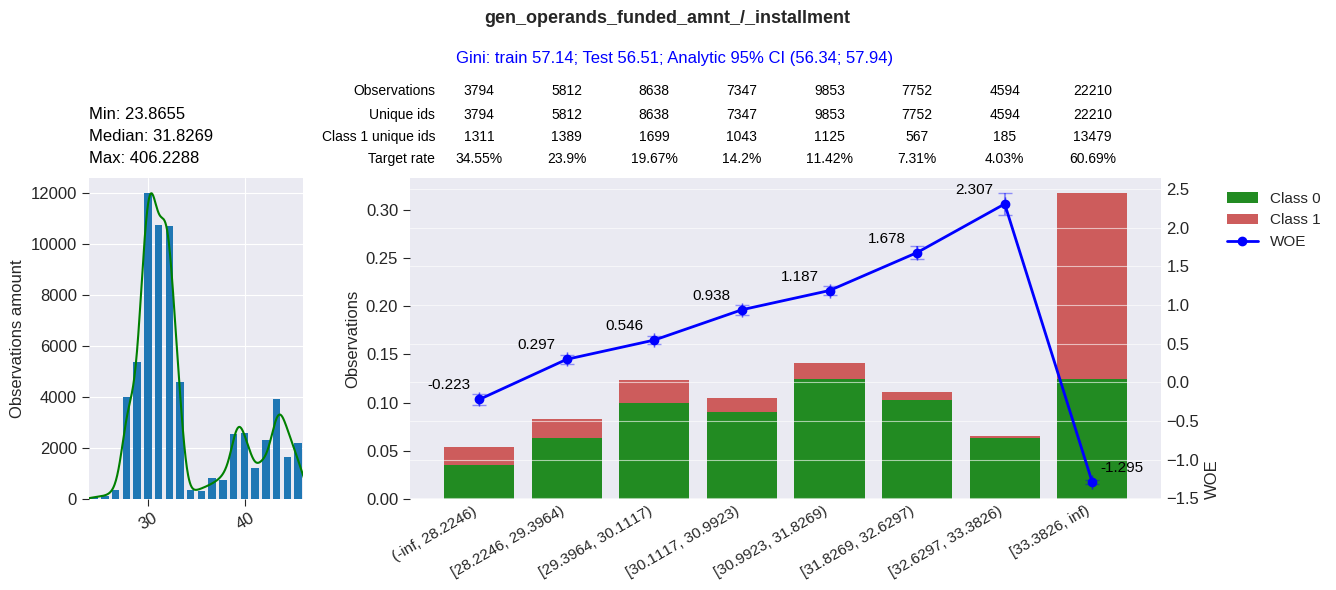

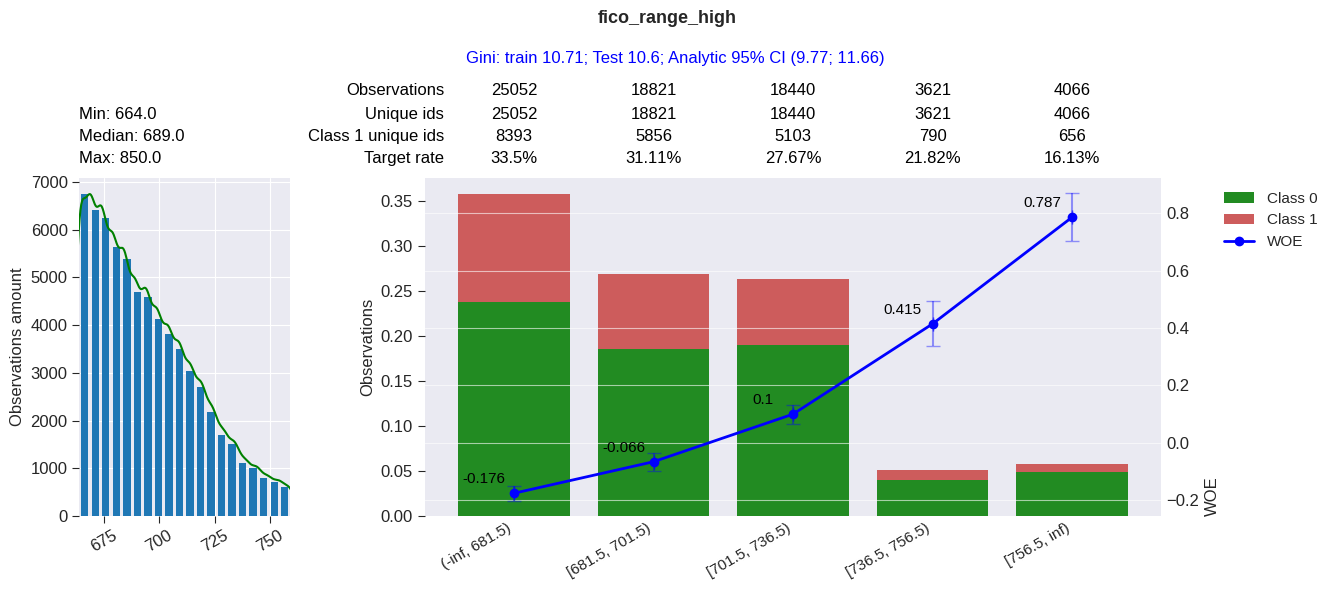

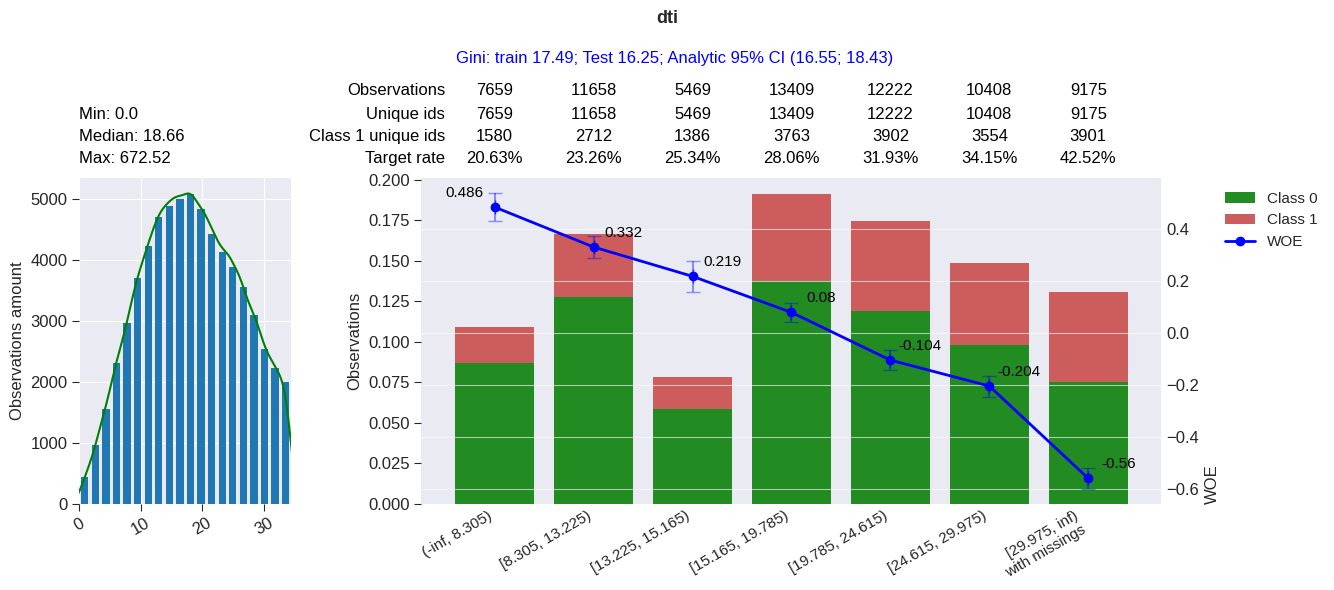

[INFO] [2023-07-21 14:06:47] The model report is saved to file auto_model.xlsx
[INFO] [2023-07-21 14:06:47] The model was successfully saved to file titanic_output/auto_model.json


In [ ]:
logreg.auto_logreg(data=None, target=None, time_column=None, id_column=None, feature_descriptions=None, n_jobs=None,
                   result_folder='', method='opt', validate=False, out='auto_model.xlsx', save_model='auto_model.json')

In [ ]:
ds.features

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'pymnt_plan',
 'purpose',
 'dti',
 'delinq_2yrs',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'recoveries',
 'collection_recovery_fee',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'tot_coll_amt',
 'tot_cur_bal',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'total_rev_hi_lim',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'acc_open_past_24mths',
 'avg_cur_bal',
 'bc_op

In [ ]:
logreg.features

['num_rev_tl_bal_gt_0_WOE',
 'gen_operands_funded_amnt_/_int_rate_WOE',
 'gen_operands_funded_amnt_/_installment_WOE',
 'fico_range_high_WOE',
 'dti_WOE']

In [ ]:
# классификатор модели (должен иметь метод fit() и атрибуты coef_, intercept_)
logreg.clf

SGDClassifier(alpha=0.001, loss='log', random_state=0)

In [ ]:
# словарь коэффициентов
logreg.coefs

{'num_rev_tl_bal_gt_0_WOE': -0.423,
 'gen_operands_funded_amnt_/_int_rate_WOE': -0.223,
 'gen_operands_funded_amnt_/_installment_WOE': -0.967,
 'fico_range_high_WOE': -0.467,
 'dti_WOE': -0.449}

In [ ]:
# константа логрега
logreg.intercept

-0.878

In [ ]:
# список коэффициентов для калибровки [a, b]
# score_calibr = a + b*score
logreg.calibration

In [ ]:
# словарь шкалы {грейд: верхняя граница PD грейда}
'''
пример мастер-шкалы:
{
'MA1': 0.00050,
'MA2': 0.00069,
'MA3': 0.00097,
'MB1': 0.0013,
'MB2': 0.0019,
'MB3': 0.0027,
'MC1': 0.0038,
'MC2': 0.0053,
'MC3': 0.0075,
'MD1': 0.010,
'MD2': 0.014,
'MD3': 0.020,
'ME1': 0.029,
'ME2': 0.041,
'ME3': 0.057,
'MF1': 0.081,
'MF2': 0.11,
'MF3': 0.16,
'MG1': 0.22,
'MG2': 0.31,
'MG3': 1
}
'''
logreg.scale

In [ ]:
logreg.report(ds=None, out='report.xlsx', sheet_name=None, pvalue_threshold=0.05, verbose=False, add_figs=None, gini_df=None,
              plotbins_config=None, metrics=None, metrics_cv=None, cv=None)

[INFO] [2023-07-21 14:07:07] The model report is saved to file report.xlsx


Gini                           \
                                            train   Test CI_lower CI_upper   
feature                                                                      
num_rev_tl_bal_gt_0_WOE                     11.40  11.13    10.46    12.35   
gen_operands_funded_amnt_/_int_rate_WOE     18.14  17.67    17.20    19.08   
gen_operands_funded_amnt_/_installment_WOE  57.14  56.51    56.34    57.94   
fico_range_high_WOE                         10.71  10.60     9.77    11.66   
dti_WOE                                     17.49  16.25    16.55    18.43   
intercept                                     NaN    NaN      NaN      NaN   
model                                       59.64  58.67    58.85    60.42   

                                           coefficient     se Wald p-value  \
                                                                     train   
feature                                                                      
num_rev_tl_bal_gt_0_WOE                         -0.423  0.048    5.349e-19   
gen_operands_funded_amnt_/_int_rate_WOE         -0.223  0.028    3.934e-15   
gen_operands_funded_amnt_/_installment_WOE      -0.967  0.009    0.000e+00   
fico_range_high_WOE                             -0.467  0.046    1.074e-24   
dti_WOE                                         -0.449  0.031    1.609e-47   
intercept                                       -0.878  0.010    0.000e+00   
model                                              NaN    NaN          NaN   

                                                          ks           vif  \
                                                 Test  train   Test  train   
feature                                                                      
num_rev_tl_bal_gt_0_WOE                     4.382e-09  0.086  0.090  1.089   
gen_operands_funded_amnt_/_int_rate_WOE     1.696e-07  0.140  0.141  1.099   
gen_operands_funded_amnt_/_installment_WOE  0.000e+00  0.483  0.475  1.142   
fico_range_high_WOE                         1.261e-11  0.083  0.086  1.075   
dti_WOE                                     3.689e-21  0.130  0.117  1.101   
intercept                                   0.000e+00    NaN    NaN    NaN   
model                                             NaN  0.485  0.482    NaN   

                                                      iv         
                                             Test  train   Test  
feature                                                          
num_rev_tl_bal_gt_0_WOE                     1.083  0.043  0.040  
gen_operands_funded_amnt_/_int_rate_WOE     1.093  0.141  0.130  
gen_operands_funded_amnt_/_installment_WOE  1.141  1.257  1.222  
fico_range_high_WOE                         1.071  0.053  0.051  
dti_WOE                                     1.098  0.098  0.089  
intercept                                     NaN    NaN    NaN  
model                                         NaN  1.251  1.144